<a href="https://colab.research.google.com/github/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 -- CNNs, AEs, GANs
https://submitty.cs.rpi.edu/courses/f22/csci4962/course_material/Homeworks/Homework%205.pdf

In [1]:
!nvidia-smi

Sat Oct 29 22:36:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# connect to google drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

import warnings
warnings.filterwarnings('ignore')

In [3]:
# !kaggle datasets download -d muratkokludataset/rice-image-dataset

In [4]:
# Set a fixed randomness
import os
import torch
import random   
import numpy as np
def seed_everything(seed=20):
    """set seed for all"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
# import dataset from kaggle
if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip -d .
clear_output()

In [6]:
# Data preprocessing
import torchvision

train_dir = 'Vegetable Images/train'
valid_dir = 'Vegetable Images/validation'
test_dir = 'Vegetable Images/test'

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root=valid_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

In [7]:
# 
label_map = {k:v for k,v in enumerate(train_dataset.classes)}
num_classes = len(label_map)

In [8]:
# Data preprocessing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Create a sample batch
sample_batch = next(iter(train_loader))
print('Batch image shape:', sample_batch[0].shape)
print('Batch label shape:', sample_batch[1].shape)

Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])


In [10]:
# Build CNN

In [25]:
# Define hyperparameters
n_epoch = 5
learning_rate = 3e-4
weight_decay = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
from torch import nn

def init_cnn(module): 
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(nn.Module):
    def __init__(self, num_classes, device):
        super().__init__()
        self.output = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.Sigmoid(),
            nn.LazyLinear(84), 
            nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )
        self.device = device
        self.to(device)

    def forward(self, image):
        image = image.to(self.device)
        output = self.output(image)
        return output


model = LeNet(num_classes, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model(sample_batch[0]).shape

torch.Size([32, 15])

In [28]:
from tqdm.autonotebook import tqdm

# Define train step
def train_step(batch, model, criterion, optimizer, device):
    optimizer.zero_grad()
    logits = model(batch[0])
    true_labels = batch[1].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model(batch[0]).detach()
    true_labels = batch[1].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc)
    return avg_train_loss_list, avg_valid_acc_list

avg_train_loss_list, avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device)


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

In [30]:
# print('Last epoch metrics:', avg_train_loss_list, avg_valid_acc_list)

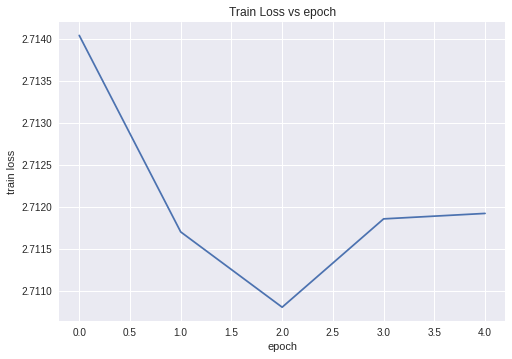

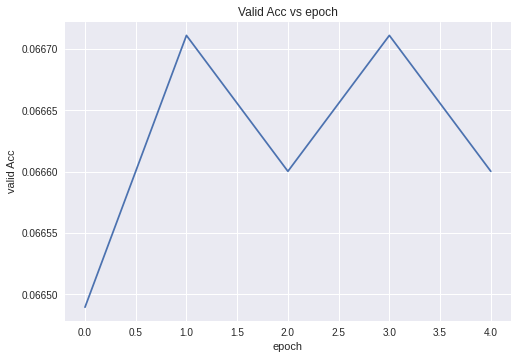

In [31]:
from matplotlib import pyplot as plt
plt.style.use('seaborn')
# Visualize train loss 
plt.plot(avg_train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('Train Loss vs epoch')
plt.show()

# Visualize valid accuracy 
plt.plot(avg_valid_acc_list)
plt.xlabel('epoch')
plt.ylabel('valid Acc')
plt.title('Valid Acc vs epoch')
plt.show()
